In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Circle
from scipy import signal

np.set_printoptions(precision=16)

In [7]:
def zplane_plot(ax, z, p, k):
    """Plot pole/zero/gain plot of discrete-time, linear-time-invariant system.

    Note that the for-loop handling might be not very efficient
    for very long FIRs

    z...array of zeros in z-plane
    p...array of poles in z-zplane
    k...gain factor

    taken from own work
    URL = ('https://github.com/spatialaudio/signals-and-systems-exercises/'
           'blob/master/sig_sys_tools.py')

    currently we don't use the ax input parameter, we rather just plot
    in hope for getting an appropriate place for it from the calling function
    """
    # draw unit circle
    Nf = 2**7
    Om = np.arange(Nf) * 2*np.pi/Nf
    plt.plot(np.cos(Om), np.sin(Om), 'C7')

    try:  # TBD: check if this pole is compensated by a zero
        circle = Circle((0, 0), radius=np.max(np.abs(p)),
                        color='C7', alpha=0.15)
        plt.gcf().gca().add_artist(circle)
    except ValueError:
        print('no pole at all, ROC is whole z-plane')

    zu, zc = np.unique(z, return_counts=True)  # find and count unique zeros
    for zui, zci in zip(zu, zc):  # plot them individually
        plt.plot(np.real(zui), np.imag(zui), ms=8,
                 color='C0', marker='o', fillstyle='none')
        if zci > 1:  # if multiple zeros exist then indicate the count
            plt.text(np.real(zui), np.imag(zui), zci)

    pu, pc = np.unique(p, return_counts=True)  # find and count unique poles
    for pui, pci in zip(pu, pc):  # plot them individually
        plt.plot(np.real(pui), np.imag(pui), ms=8,
                 color='C0', marker='x')
        if pci > 1:  # if multiple poles exist then indicate the count
            plt.text(np.real(pui), np.imag(pui), pci)

    plt.text(0, +1, 'k={0:f}'.format(k))
    plt.text(0, -1, 'ROC for causal: white')
    plt.axis('square')
    plt.xlabel(r'$\Re\{z\}$')
    plt.ylabel(r'$\Im\{z\}$')
    plt.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')


def bode_plot(b, a, N=2**10, fig=None):  # for IIR if length of b and a are the same
    if fig is None:
        fig = plt.figure()

    z, p, gain = signal.tf2zpk(b, a)
    W, Hd = signal.freqz(b, a, N, whole=True)

    # print('number of poles:', len(p), '\npole(s) at:', p,
    #      '\nnumber of zeros:', len(z), '\nzero(s) at:', z)

    gs = fig.add_gridspec(2, 2)
    # magnitude
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(W/np.pi, np.abs(Hd), "C0",
             label=r'$|H(\Omega)|$)',
             linewidth=2)
    ax1.set_xlim(0, 2)
    ax1.set_xticks(np.arange(0, 9)/4)
    ax1.set_xlabel(r'$\Omega \,/\, \pi$', color='k')
    ax1.set_ylabel(r'$|H|$', color='k')
    ax1.set_title("Magnitude response", color='k')
    ax1.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')

    # phase
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(W/np.pi, (np.angle(Hd)*180/np.pi), "C0",
             label=r'$\mathrm{angle}(H('r'\omega))$',
             linewidth=2)
    ax2.set_xlim(0, 2)
    ax2.set_xticks(np.arange(0, 9)/4)
    ax2.set_xlabel(r'$\Omega \,/\, \pi$', color='k')
    ax2.set_ylabel(r'$\angle(H)$ / deg', color='k')
    ax2.set_title("Phase response", color='k')
    ax2.grid(True, which="both", axis="both",
             linestyle="-", linewidth=0.5, color='C7')

    # zplane
    ax3 = fig.add_subplot(gs[0, 1])
    zplane_plot(ax3, z, p, gain)

    # impulse response
    N = 2**4  # here specially chosen for the examples below
    k = np.arange(0, N)
    x = np.zeros(N)
    x[0] = 1
    h = signal.lfilter(b, a, x)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.stem(k, h, linefmt='C0', markerfmt='C0o',
             basefmt='C0:')
    ax4.set_xlabel(r'$k$')
    ax4.set_ylabel(r'$h[k]$')
    ax4.set_title('Impulse Response')
    ax4.grid(True, which="both", axis="both", linestyle="-",
             linewidth=0.5, color='C7')


# some defaults for the upcoming code:
figsize = (12, 9)

In [8]:
# taken from lecture's repository
# https://github.com/spatialaudio/digital-signal-processing-lecture/blob/master/filter_design/audiofilter.py


def bilinear_biquad(B, A, fs):
    """Get the bilinear transform of a 2nd-order Laplace transform.

    bilinear transform H(s)->H(z) with s=2*fs*(z-1)/(z+1)

    input:
    B[0] = B0   B[1] = B1   B[2] = B2
    A[0] = A0   A[1] = A1   A[2] = A2
    fs...sampling frequency in Hz
           Y(s)   B0*s^2+B1*s+B2   B[0]*s^2+B[1]*s+B[2]
    H(s) = ---- = -------------- = --------------------
           X(s)   A0*s^2+A1*s+A2   A[0]*s^2+A[1]*s+A[2]
    output:
    b[0] = b0   b[1] = b1   b[2] = b2
    a[0] = 1    a[1] = a1   a[2] = a2
           Y(z)   b2*z^-2+b1*z^-1+b0   b[2]*z^-2+b[1]*z^-1+b[0]
    H(z) = ---- = ------------------ = ------------------------
           X(z)   a2*z^-2+a1*z^-1+ 1   a[2]*z^-2+a[1]*z^-1+a[0]
    """
    A0, A1, A2 = A
    B0, B1, B2 = B
    fs2 = fs**2

    a0 = A2 + 2*A1*fs + 4*A0*fs2
    b0 = B2 + 2*B1*fs + 4*B0*fs2

    b1 = 2*B2 - 8*B0*fs2
    a1 = 2*A2 - 8*A0*fs2

    b2 = B2 - 2*B1*fs + 4*B0*fs2
    a2 = A2 - 2*A1*fs + 4*A0*fs2

    b = np.array([b0, b1, b2]) / a0
    a = np.array([a0, a1, a2]) / a0

    return b, a


def f_prewarping(f, fs):
    """Do the frequency prewarping for bilinear transform.

    input:
    f...analog frequency in Hz to be prewarped
    fs...sampling frequency in Hz
    output:
    prewarped angular frequency wpre in rad/s
    """
    return 2*fs*np.tan(np.pi*f/fs)

In [9]:
def pz_placement(zr, za, pr, pa):
    z = zr * np.exp(+1j*za)
    p = pr * np.exp(+1j*pa)

    b = np.poly([z, np.conj(z)])
    a = np.poly([p, np.conj(p)])

    bode_plot(b, a, fig=plt.figure(figsize=figsize))

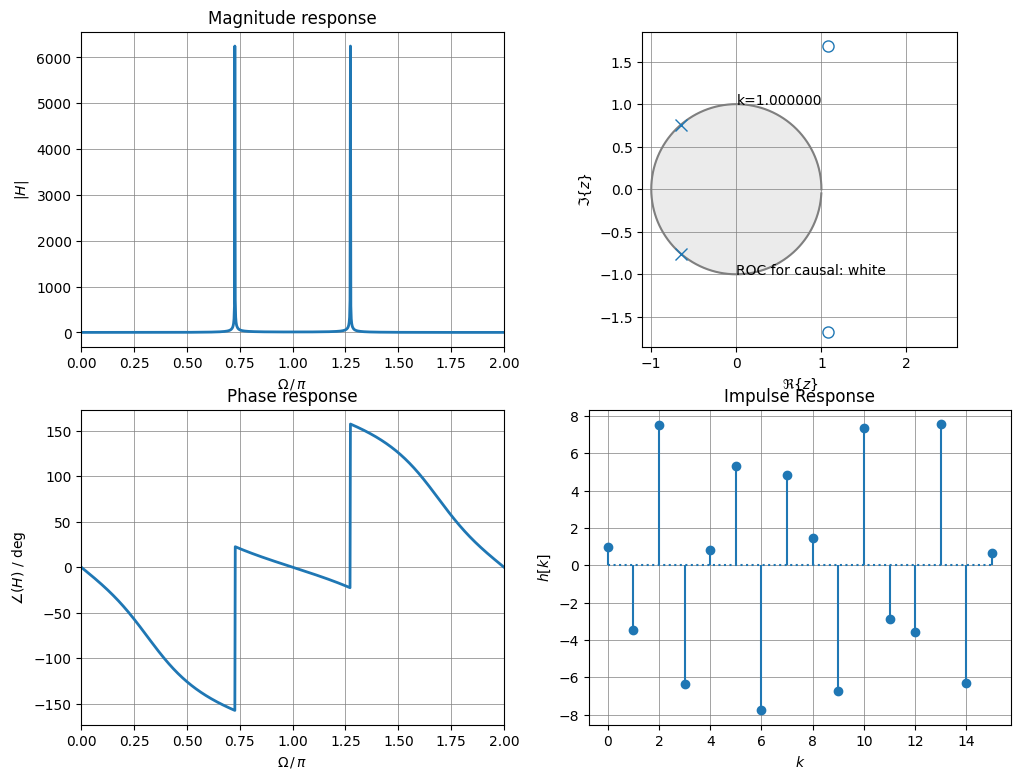

In [11]:

pz_placement(zr=2, za=1, pr=1, pa=4)